In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download
import lamindb as ln

from scprint.tasks import Embedder
from scprint.tasks.cell_emb import display_confusion_matrix
import pandas as pd

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from anndata import AnnData
from scdataloader.utils import translate
import bionty as bt
from scprint.tasks.cell_emb import compute_classification

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from scdataloader import SimpleAnnDataset, Collator, DataModule
from torch.utils.data import DataLoader

import lamindb as ln

%load_ext autoreload
%autoreload 2

import torch
import scipy.sparse

torch.set_float32_matmul_precision("medium")

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [3]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../models/ji9krimq.ckpt"
# w937u4o1.ckpt'
# da6ao55o.ckpt # 649
# 1lzuxvg0.ckpt # 677


In [ ]:
model = scPrint.load_from_checkpoint(
    model_checkpoint_file, precpt_gene_emb=None, gene_pos_file=None, max_cont_len=None,
)
model = model.to("cuda")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd28528d610>>
Traceback (most recent call last):
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [2]:
LOC = "notebooks/scPRINT-2-repro-notebooks/"#"./"

In [3]:
da = sc.read(LOC+"data/task_3_embed.h5ad")

In [5]:
map_to_val = {n: i for i, n in enumerate(set(da.obs["batch"].unique()))}
da.obs["batch"] = da.obs["batch"].map(map_to_val)

In [8]:
# Prepare data for fine-tuning (using the cat/tiger dataset from above)
# Split data into train/val
n_train = int(0.5 * len(da))
train_idx = np.random.choice(len(da), n_train, replace=False)
val_idx = np.setdiff1d(np.arange(len(da)), train_idx)

train_data = da[train_idx].copy()
val_data = da[val_idx].copy()

print(f"Training data: {train_data.shape}")
print(f"Validation data: {val_data.shape}")

mencoders = {}
for k, v in model.label_decoders.items():
    mencoders[k] = {va: ke for ke, va in v.items()}
# this needs to remain its original name as it is expect like that by collator, otherwise need to send org_to_id as params
mencoders.pop("organism_ontology_term_id")

# Create datasets
train_dataset = SimpleAnnDataset(
    train_data,
    obs_to_output=["cell_type_ontology_term_id", "batch", "organism_ontology_term_id"],
    get_knn_cells=model.expr_emb_style == "metacell",
    encoder=mencoders,
)

val_dataset = SimpleAnnDataset(
    val_data,
    obs_to_output=["cell_type_ontology_term_id", "batch", "organism_ontology_term_id"],
    get_knn_cells=model.expr_emb_style == "metacell",
    encoder=mencoders,
)

# Create collator
collator = Collator(
    organisms=model.organisms,
    valid_genes=model.genes,
    class_names=["cell_type_ontology_term_id", "batch"],
    how="random expr",  # or "all expr" for full expression
    max_len=2800,
    add_zero_genes=0,
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    collate_fn=collator,
    batch_size=16,  # Adjust based on GPU memory
    num_workers=4,
    shuffle=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    collate_fn=collator,
    batch_size=32,
    num_workers=4,
    shuffle=True,
    pin_memory=True,
)

Training data: (13600, 57066)
Validation data: (13600, 57066)


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


In [9]:
d_model_org = 8
d_model_cell = 256  # 128

batch_cls = torch.nn.Sequential(
    # torch.nn.Linear(d_model_org, d_model_org * 8),
    torch.nn.Linear(d_model_cell, d_model_org * 8),
    torch.nn.ReLU(),
    torch.nn.Linear(d_model_org * 8, len(set(da.obs["batch"].unique()))),
)
batch_cls = batch_cls.to(model.device)

batch_emb = torch.nn.Embedding(len(set(da.obs["batch"].unique())), d_model_cell).to(
    model.device
)

In [10]:
for val in model.parameters():
    val.requires_grad = False
    # setting all to TRUE

for val in model.cell_transformer.parameters():
    val.requires_grad = True
for val in model.transformer.blocks[7].parameters():
    val.requires_grad = True
for i in model.transformer.blocks:
    i.cross_attn.requires_grad = True
# for val in model.compressor.parameters():
#    val.requires_grad = True
for val in model.cls_decoders["cell_type_ontology_term_id"].parameters():
    val.requires_grad = True

In [11]:
def mmd_loss(X, Y):
    """
    Compute Maximum Mean Discrepancy (MMD) loss between two 2D embedding matrices.

    Args:
        X: Tensor of shape (n1, emb_dim) - first set of embeddings
        Y: Tensor of shape (n2, emb_dim) - second set of embeddings

    Returns:
        MMD loss value (negative to encourage dissimilarity)
    """

    def rbf_kernel(x, y, sigma):
        """Compute RBF kernel between two sets of vectors"""
        distance = torch.cdist(x, y, p=2) ** 2
        return torch.exp(-distance / (2 * sigma**2))

    def energy_kernel(x, y):
        """Compute Energy kernel between two sets of vectors"""
        distance = torch.cdist(x, y, p=2)
        return -distance

    # Use multiple kernel bandwidths for better performance
    sigmas = [0]  # [0.1, 1.0, 10.0]
    mmd_loss = 0.0

    for sigma in sigmas:
        # K(X, X) - kernel matrix within first group (n1 x n1)
        # k_xx = rbf_kernel(X, X, sigma)
        k_xx = energy_kernel(X, X)
        # K(Y, Y) - kernel matrix within second group (n2 x n2)
        # k_yy = rbf_kernel(Y, Y, sigma)
        k_yy = energy_kernel(Y, Y)
        # K(X, Y) - kernel matrix between groups (n1 x n2)
        # k_xy = rbf_kernel(X, Y, sigma)
        k_xy = energy_kernel(X, Y)

        # Unbiased MMD estimation
        n1 = X.shape[0]
        n2 = Y.shape[0]

        # Remove diagonal elements for unbiased estimation of K(X,X) and K(Y,Y)
        # For K(X,X): exclude diagonal
        if n1 > 1:
            mask_xx = 1 - torch.eye(n1, device=X.device)
            k_xx_term = (k_xx * mask_xx).sum() / (n1 * (n1 - 1))
        else:
            k_xx_term = 0.0

        # For K(Y,Y): exclude diagonal
        if n2 > 1:
            mask_yy = 1 - torch.eye(n2, device=Y.device)
            k_yy_term = (k_yy * mask_yy).sum() / (n2 * (n2 - 1))
        else:
            k_yy_term = 0.0

        # For K(X,Y): use all elements (no diagonal to exclude)
        k_xy_term = k_xy.mean()

        # MMD^2 = E[K(X,X)] + E[K(Y,Y)] - 2*E[K(X,Y)]
        mmd_squared = k_xx_term + k_yy_term - 2 * k_xy_term
        mmd_loss += mmd_squared

    # Return negative MMD to encourage dissimilarity (higher MMD = more different)
    return mmd_loss / len(sigmas)

In [12]:
def batch_corr_pass(batch):
    gene_pos = batch["genes"].to(model.device)
    expression = batch["x"].to(model.device)
    depth = batch["depth"].to(model.device)
    class_elem = batch["class"].long().to(model.device)
    total_loss = 0

    # Forward pass with automatic mixed precisio^n
    with torch.cuda.amp.autocast():
        # Forward pass
        output = model.forward(
            gene_pos,
            expression,
            req_depth=depth,
            depth_mult=expression.sum(1),
            do_class=True,
            metacell_token=torch.zeros_like(depth),
        )
        ## adaptor on ct_emb
        # ctpos = model.classes.index("cell_type_ontology_term_id") + 1
        # emb = output["output_cell_embs"][:, ctpos, :]
        #
        # output["output_cell_embs"][:, ctpos, :] = adaptor_layer(
        #    torch.cat([emb, class_elem[:, 1].unsqueeze(1).float()], dim=1)
        # )

        batch_pos = model.classes.index("organism_ontology_term_id") + 1
        output["output_cell_embs"][:, batch_pos, :] = batch_emb(class_elem[:, 1])

        ## generate expr loss
        output_gen = model._generate(
            cell_embs=output["output_cell_embs"],
            gene_pos=gene_pos,
            depth_mult=expression.sum(1),
            req_depth=depth,
        )
        if "zero_logits" in output_gen:
            loss_expr = loss.zinb(
                theta=output_gen["disp"],
                pi=output_gen["zero_logits"],
                mu=output_gen["mean"],
                target=expression,
            )
            if model.zinb_and_mse:
                loss_expr += (
                    loss.mse(
                        input=torch.log(output_gen["mean"] + 1)
                        * (1 - torch.sigmoid(output_gen["zero_logits"])),
                        target=torch.log(expression + 1),
                    )
                    / 10  # scale to make it more similar to the zinb
                )
        else:
            loss_expr = loss.mse(
                input=torch.log(output_gen["mean"] + 1),
                target=torch.log(expression + 1),
            )
        # Add expression loss to total
        total_loss += loss_expr

        # ct clss
        cls_output = output.get("cls_output_cell_type_ontology_term_id")
        # ct_output = output["output_cell_embs"][:, ctpos, :]
        # cls_output = model.cls_decoders["cell_type_ontology_term_id"](ct_output)
        cls_loss = loss.hierarchical_classification(
            pred=cls_output,
            cl=class_elem[:, 0],
            labels_hierarchy=model.mat_labels_hierarchy.get(
                "cell_type_ontology_term_id"
            ).to("cuda"),
        )
        pos = model.classes.index("organism_ontology_term_id") + 1
        org_emb = (
            output["compressed_cell_embs"][pos]
            if model.compressor is not None
            else output["input_cell_embs"][:, pos, :]
        )
        cls_loss += F.cross_entropy(
            input=batch_cls(org_emb),
            target=class_elem[:, 1],
        )
        total_loss += cls_loss

        pos = model.classes.index("cell_type_ontology_term_id") + 1
        # Apply gradient reversal to the input embedding
        selected_emb = (
            output["compressed_cell_embs"][pos]
            if model.compressor is not None
            else output["input_cell_embs"][:, pos, :]
        )
        X, Y = selected_emb[class_elem[:, 1] == 1], selected_emb[class_elem[:, 1] == 0]

        mmd = mmd_loss(X, Y)
        if torch.isnan(mmd):
            print("mmd nan")
        mmd = mmd.item() if not torch.isnan(mmd) else 0

        # Add adversarial loss to total loss
        total_loss += mmd * 3
        # total_loss += output["vae_kl_loss"] * 0.001
    return total_loss, cls_loss, loss_expr, mmd

In [13]:
# Alternative: Manual Training Loop (for more control)
# If you prefer to have more control over the training process
from tqdm import tqdm
import torch.nn.functional as F
from scprint.model import loss

num_epochs = 4
lr = 0.0002

# Setup optimizer
all_params = (
    list(model.parameters())
    + list(batch_cls.parameters())
    + list(batch_emb.parameters())
)
optimizer = torch.optim.AdamW(
    all_params, lr=lr, weight_decay=0.01, betas=(0.9, 0.999), eps=1e-8
)

# Setup scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.2, patience=1
)

# Setup automatic mixed precision
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

_ = model.train()

for k, i in model.mat_labels_hierarchy.items():
    model.mat_labels_hierarchy[k] = i.to(model.device)

/local/scratch/tmp/ipykernel_2469393/2033321161.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


In [14]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Training phase
    train_loss = 0.0
    train_steps = 0
    avg_adv = 0
    avg_expr = 0
    avg_cls = 0
    avg_mmd = 0

    # pbar = tqdm(train_loader, desc="Training")
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        total_loss, cls_loss, loss_expr, mmd = batch_corr_pass(batch)
        # Backward pass
        scaler.scale(total_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += total_loss.item()
        train_steps += 1
        avg_cls += cls_loss.item()
        avg_expr += loss_expr.item()
        avg_mmd += mmd
        # Update progress bar
        # if batch_idx % 35 == 0:
        # print(
        #    f"avg_loss {train_loss / train_steps:.4f}, avg_cls {avg_cls / train_steps:.4f}, avg_expr {avg_expr / train_steps:.4f}, avg_adv {avg_mmd/ train_steps:.4f}"
        # )
        # pbar.set_postfix(
        #    {
        #        "loss": f"{total_loss.item():.4f}",
        #        "avg_loss": f"{train_loss / train_steps:.4f}",
        #        "cls_loss": f"{cls_loss.item():.4f}",
        #        "mmd_loss": f"{mmd:.4f}",
        #        "expr_loss": f"{loss_expr.item():.4f}",
        #    }
        # )

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_steps = 0
    val_loss_expr = 0.0
    val_mmd = 0.0
    val_cls = 0.0
    val_loss_to_prt = 0.0

    with torch.no_grad():
        for batch in val_loader:  # tqdm(val_loader, desc="Validation"):
            loss_val, cls_loss, loss_expr, mmd = batch_corr_pass(batch)
            val_loss_to_prt += loss_val.item()
            val_loss += loss_val.item()
            val_steps += 1
            val_loss_expr += loss_expr.item()
            val_mmd += mmd
            val_cls += cls_loss.item()
    try:
        avg_val_loss = val_loss_to_prt / val_steps
        avg_train_loss = train_loss / train_steps
    except ZeroDivisionError:
        print("Error: Division by zero occurred while calculating average losses.")
        avg_train_loss = 0
    print(
        "cls_loss: {:.4f}, mmd_loss: {:.4f}, expr_loss: {:.4f}".format(
            val_cls / val_steps, val_mmd / val_steps, val_loss_expr / val_steps
        )
    )
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Store LR before scheduler step for comparison
    lr_before = optimizer.param_groups[0]["lr"]

    # Update learning rate
    scheduler.step(val_mmd / val_steps)

    # Check if LR was reduced
    lr_after = optimizer.param_groups[0]["lr"]
    if lr_after < lr_before:
        print(
            f"🔻 Learning rate reduced from {lr_before:.2e} to {lr_after:.2e} (factor: {lr_after / lr_before:.3f})"
        )
    else:
        print(f"✅ Learning rate unchanged: {lr_after:.2e}")

print("Manual fine-tuning completed!")


Epoch 1/4
Current learning rate: 2.00e-04


/local/scratch/tmp/ipykernel_2469393/326240407.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


mmd nan


cls_loss: 0.0063, mmd_loss: 3.4693, expr_loss: 1.0143
Train Loss: 9.9273, Val Loss: 11.4284
✅ Learning rate unchanged: 2.00e-04

Epoch 2/8
Current learning rate: 2.00e-04


cls_loss: 0.0047, mmd_loss: 4.7959, expr_loss: 0.9042
Train Loss: 17.4370, Val Loss: 15.2966
✅ Learning rate unchanged: 2.00e-04

Epoch 3/8
Current learning rate: 2.00e-04


mmd nan


cls_loss: 0.0050, mmd_loss: 7.1534, expr_loss: 0.8949
Train Loss: 19.4451, Val Loss: 22.3601
🔻 Learning rate reduced from 2.00e-04 to 4.00e-05 (factor: 0.200)

Epoch 4/8
Current learning rate: 4.00e-05


cls_loss: 0.0034, mmd_loss: 4.9842, expr_loss: 0.8906
Train Loss: 18.6255, Val Loss: 15.8465
✅ Learning rate unchanged: 4.00e-05

Epoch 5/8
Current learning rate: 4.00e-05


cls_loss: 0.0036, mmd_loss: 5.0431, expr_loss: 0.8892
Train Loss: 15.5299, Val Loss: 16.0221
🔻 Learning rate reduced from 4.00e-05 to 8.00e-06 (factor: 0.200)

Epoch 6/8
Current learning rate: 8.00e-06


mmd nan


cls_loss: 0.0036, mmd_loss: 4.5877, expr_loss: 0.8883
Train Loss: 14.8725, Val Loss: 14.6551
✅ Learning rate unchanged: 8.00e-06

Epoch 7/8
Current learning rate: 8.00e-06


cls_loss: 0.0037, mmd_loss: 4.6597, expr_loss: 0.8879
Train Loss: 14.5315, Val Loss: 14.8705
🔻 Learning rate reduced from 8.00e-06 to 1.60e-06 (factor: 0.200)

Epoch 8/8
Current learning rate: 1.60e-06


cls_loss: 0.0038, mmd_loss: 4.4756, expr_loss: 0.8878
Train Loss: 14.7087, Val Loss: 14.3185
✅ Learning rate unchanged: 1.60e-06
Manual fine-tuning completed!


In [15]:
import lightning as L

checkpoint = {
    "epoch": epoch,
    "global_step": (1 + epoch) * batch_idx,
    "pytorch-lightning_version": L.__version__,
    "state_dict": model.state_dict(),
    "optimizer_states": [optimizer.state_dict()],
    "lr_schedulers": [scheduler.state_dict()],
    "hparams_name": None,
    "loops": None,
    "callbacks": None,
    "hyper_parameters": model.hparams,
}
torch.save(checkpoint, "fit_2.ckpt")

In [16]:
# model.load_state_dict(torch.load("fit_2.ckpt")["state_dict"])

In [4]:
model = scPrint.load_from_checkpoint(
    "fit_2.ckpt", precpt_gene_emb=None, attention="normal"
)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [8]:
embed = Embedder(
    how="random expr",
    max_len=2800,
    num_workers=8,
    pred_embedding=["cell_type_ontology_term_id"],
    doplot=False,
    save_every=10_000,
    keep_all_labels_pred=True
)

In [9]:
da, metrics = embed(model, da)

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


 37%|███▋      | 156/425 [01:40<02:49,  1.58it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 10048 × 21550
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


 74%|███████▎  | 313/425 [03:33<01:10,  1.58it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 10048 × 21550
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


100%|██████████| 425/425 [04:59<00:00,  1.42it/s]


logging the anndata
AnnData object with n_obs × n_vars = 7104 × 21550
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


In [19]:
compute_classification(
    n_adata,
    ["cell_type_ontology_term_id"],
    label_decoders=model.label_decoders,
    labels_hierarchy=model.labels_hierarchy,
)

NameError: name 'compute_classification' is not defined

In [11]:
loc = da.obs.columns[da.obs.columns.str.startswith("CL:")]
pred = da.obs.loc[:, loc]

In [13]:
da.obs['pred_cell_type_ontology_term_id'] = loc[pred.values.argmax(1)].values
compute_classification(
    da,
    ["cell_type_ontology_term_id"],
    label_decoders=model.label_decoders,
    labels_hierarchy=model.labels_hierarchy,
)

{'cell_type_ontology_term_id': {'accuracy': 0.8561764705882353,
  'macro': 0.7774221671417577,
  'micro': 0.8561764705882353,
  'weighted': 0.8410787776598067}}

In [16]:
from scprint.utils.graph_refinement import zero_shot_annotation_with_refinement

In [20]:
sc.pp.normalize_total(da, target_sum=1e4)
sc.pp.log1p(da)
sc.pp.pca(da)

In [27]:
da.obs['pred_cell_type_ontology_term_id'] = loc[zero_shot_annotation_with_refinement(pred.values, da)].values
compute_classification(
    da,
    ["cell_type_ontology_term_id"],
    label_decoders=model.label_decoders,
    labels_hierarchy=model.labels_hierarchy,
)

PairwiseArrays with keys: distances, connectivities


{'cell_type_ontology_term_id': {'accuracy': 0.8591911764705882,
  'macro': 0.7790304722582386,
  'micro': 0.8591911764705882,
  'weighted': 0.8454588177282696}}

In [ ]:
LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/"

'notebooks/scPRINT-2-repro-notebooks/'

In [33]:
da

AnnData object with n_obs × n_vars = 27200 × 57066
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'cell_type', 'batch', 'barcode', 'celltype', 'percent.mt', 'integrated_snn_res.1', 'NewCelltype', 'n_genes', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'CL:0000001', 'CL:0000003', 'CL:0000019', 'CL:0000023', 'CL:0000024', 'CL:0000032', 'CL:0000047', 'CL:0000049', 'CL:0000050', 'CL:0000051', 'CL:0000062', 'CL:0000091', 'CL:0000092', 'CL:0000097', 'CL:0000114', 'CL:0000119', 'CL:0000121', 'CL:0000122', 'CL:0000128', 'CL:0000131', 'CL:0000132', 'CL:0000133', 'CL:0000138', 'CL:0000155', 'CL:000015

In [32]:
da.write(LOC+"ft_embedded_task3.h5ad")

... storing 'pred_cell_type_ontology_term_id' as categorical


In [30]:
da.obsm['X_pca'] = sc.pp.pca(da.obsm['scprint_emb'], n_comps=50)
da.obs['pred_cell_type_ontology_term_id'] = loc[zero_shot_annotation_with_refinement(pred.values, da)].values
compute_classification(
    da,
    ["cell_type_ontology_term_id"],
    label_decoders=model.label_decoders,
    labels_hierarchy=model.labels_hierarchy,
)

PairwiseArrays with keys: distances, connectivities


{'cell_type_ontology_term_id': {'accuracy': 0.8591911764705882,
  'macro': 0.7790304722582386,
  'micro': 0.8591911764705882,
  'weighted': 0.8454588177282696}}

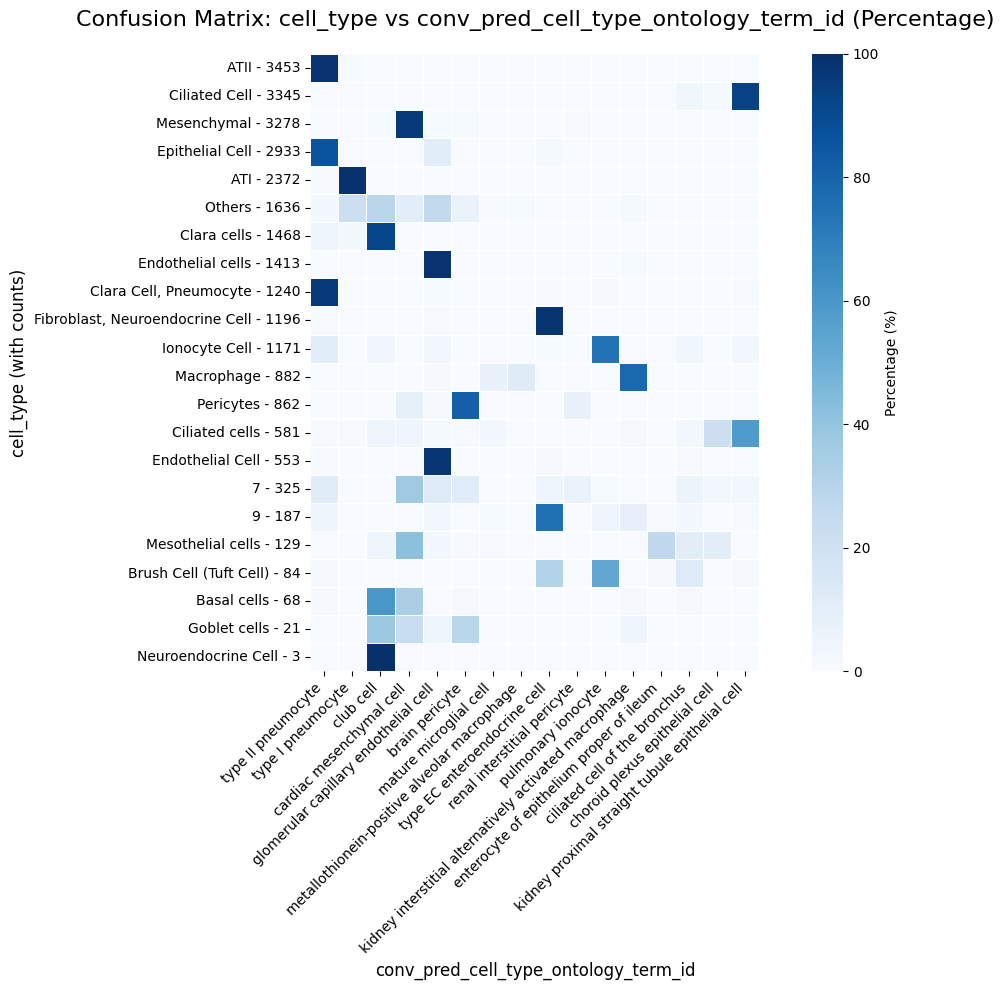

In [ ]:
display_confusion_matrix(da)

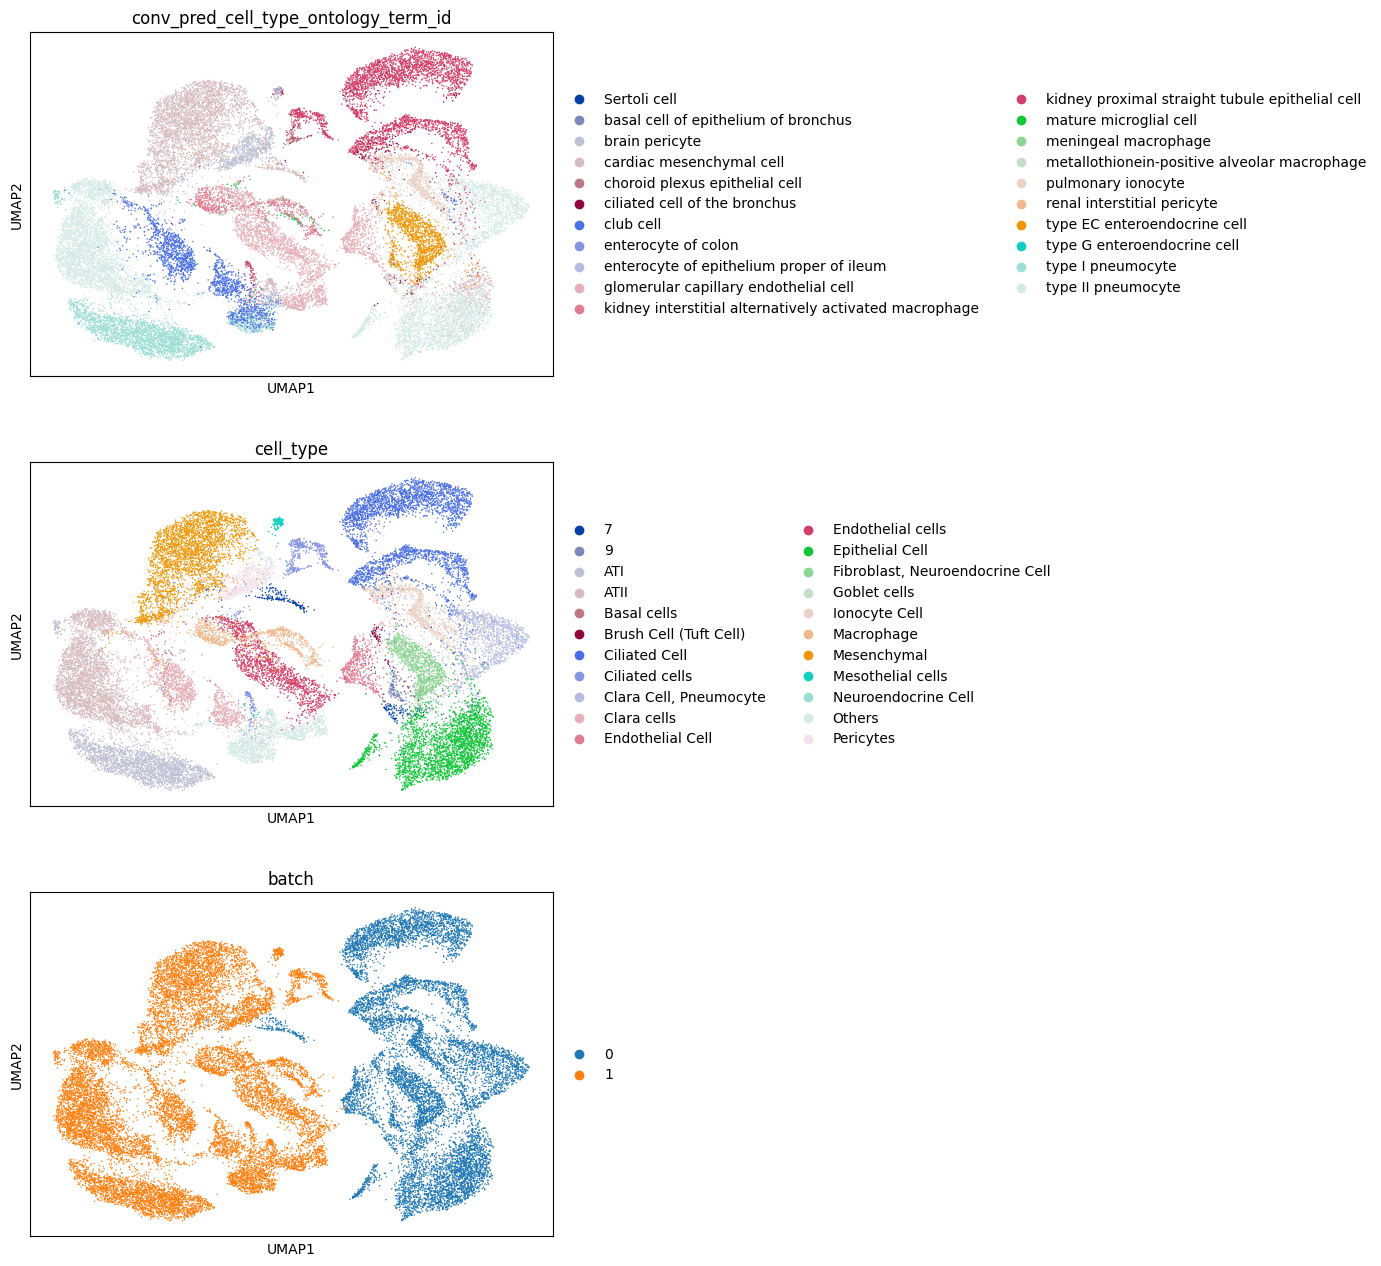

In [ ]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb_cell_type_ontology_term_id")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

In [14]:
n_adata.obs.columns

,orig.ident,nCount_RNA,nFeature_RNA,seurat_clusters,cell_type,batch,barcode,celltype,percent.mt,integrated_snn_res.1,NewCelltype,n_genes,organism_ontology_term_id,nnz,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier,assay_ontology_term_id,cell_type_ontology_term_id,pred_cell_type_ontology_term_id,pred_tissue_ontology_term_id,pred_disease_ontology_term_id,pred_age_group,pred_assay_ontology_term_id,pred_self_reported_ethnicity_ontology_term_id,pred_sex_ontology_term_id,pred_organism_ontology_term_id,pred_cell_culture,conv_pred_cell_type_ontology_term_id,conv_pred_tissue_ontology_term_id,conv_pred_disease_ontology_term_id,conv_pred_age_group,conv_pred_assay_ontology_term_id,conv_pred_self_reported_ethnicity_ontology_term_id
a0e17a6e-ace5-4901-9a8f-12cb0fb7cdec,cat,769,618,26,Epithelial Cell,1,NaN,Unknown,NaN,26,Unknown,505,NCBITaxon:10090,505,498,6.212606,567.0,6.342122,8.465608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,EFO:0030003,CL:0000066,CL:1001005,UBERON:0012168,PATO:0000461,HsapDv:0000262,EFO:0030026,HANCESTRO:0321,PATO:0000384,NCBITaxon:10090,False,glomerular capillary endothelial cell,umbilical cord blood,normal,newborn stage (0-28 days),sci-Plex,Finnish
ae64e737-d5b7-4f6c-a7ec-b2bb5da63899,cat,4112,2113,28,Ionocyte Cell,1,NaN,Secretory cells,NaN,28,Secretory cells,1762,NCBITaxon:10090,1762,1739,7.461640,2947.0,7.988882,6.990159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,EFO:0030003,CL:0005006,CL:0017000,UBERON:0001049,PATO:0000461,HsapDv:0000262,EFO:0030026,HANCESTRO:0321,PATO:0000383,NCBITaxon:10090,False,pulmonary ionocyte,neural tube,normal,newborn stage (0-28 days),sci-Plex,Finnish
17ac365a-58a5-455a-98e5-2528bd34783b,cat,11126,3722,18,Ciliated Cell,1,NaN,Fibroblasts,NaN,18,Fibroblasts,3061,NCBITaxon:10090,3061,3015,8.011687,7878.0,8.971956,6.791064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,EFO:0030003,CL:0000064,CL:1000839,UBERON:0003902,PATO:0000461,HsapDv:0000015,EFO:0030026,HANCESTRO:0321,PATO:0000383,NCBITaxon:10090,False,kidney proximal straight tubule epithelial cell,retinal neural layer,normal,organogenesis stage,sci-Plex,Finnish
cfa49246-9bdd-4349-a716-cb004fb22548,cat,1007,768,13,Ciliated Cell,1,NaN,Unknown,NaN,13,Unknown,633,NCBITaxon:10090,633,617,6.426488,730.0,6.594413,8.082192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,EFO:0030003,CL:0000064,CL:0000706,UBERON:0013682,PATO:0000461,HsapDv:0000015,EFO:0030026,HANCESTRO:0321,PATO:0000383,NCBITaxon:10090,True,choroid plexus epithelial cell,peripheral region of retina,normal,organogenesis stage,sci-Plex,Finnish
e263cb1f-bfaf-4c94-b98f-4913cd911d55,cat,21992,5483,4,Ionocyte Cell,1,NaN,Endothelial cells,NaN,4,Endothelial cells,4495,NCBITaxon:10090,4495,4432,8.396832,15780.0,9.666562,4.930292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,EFO:0030003,CL:0005006,CL:0017000,UBERON:0001049,PATO:0000461,HsapDv:0000015,EFO:0030026,HANCESTRO:0321,PATO:0000383,NCBITaxon:10090,True,pulmonary ionocyte,neural tube,normal,organogenesis stage,sci-Plex,Finnish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f19eb3ec-a628-4350-936d-3f1b9117639d,tiger,10738,3888,31,Endothelial cells,0,NaN,Endothelial cells,NaN,31,Endothelial cells,3180,NCBITaxon:10090,3180,3137,8.051341,7841.0,8.967249,6.644561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,EFO:0030003,CL:0000115,CL:1001005,UBERON:0012168,PATO:0000461,HsapDv:0000262,EFO:0030026,HANCESTRO:0321,PATO:0000383,NCBITaxon:10090,False,glomerular capillary endothelial cell,umbilical cord blood,normal,newborn stage (0-28 days),sci-Plex,Finnish
3c76a861-57ef-4aea-83b3-d43ec63ccf23,tiger,2945,1662,19,ATI,0,NaN,ATI,NaN,19,ATI,1322,NCBITaxon:1009

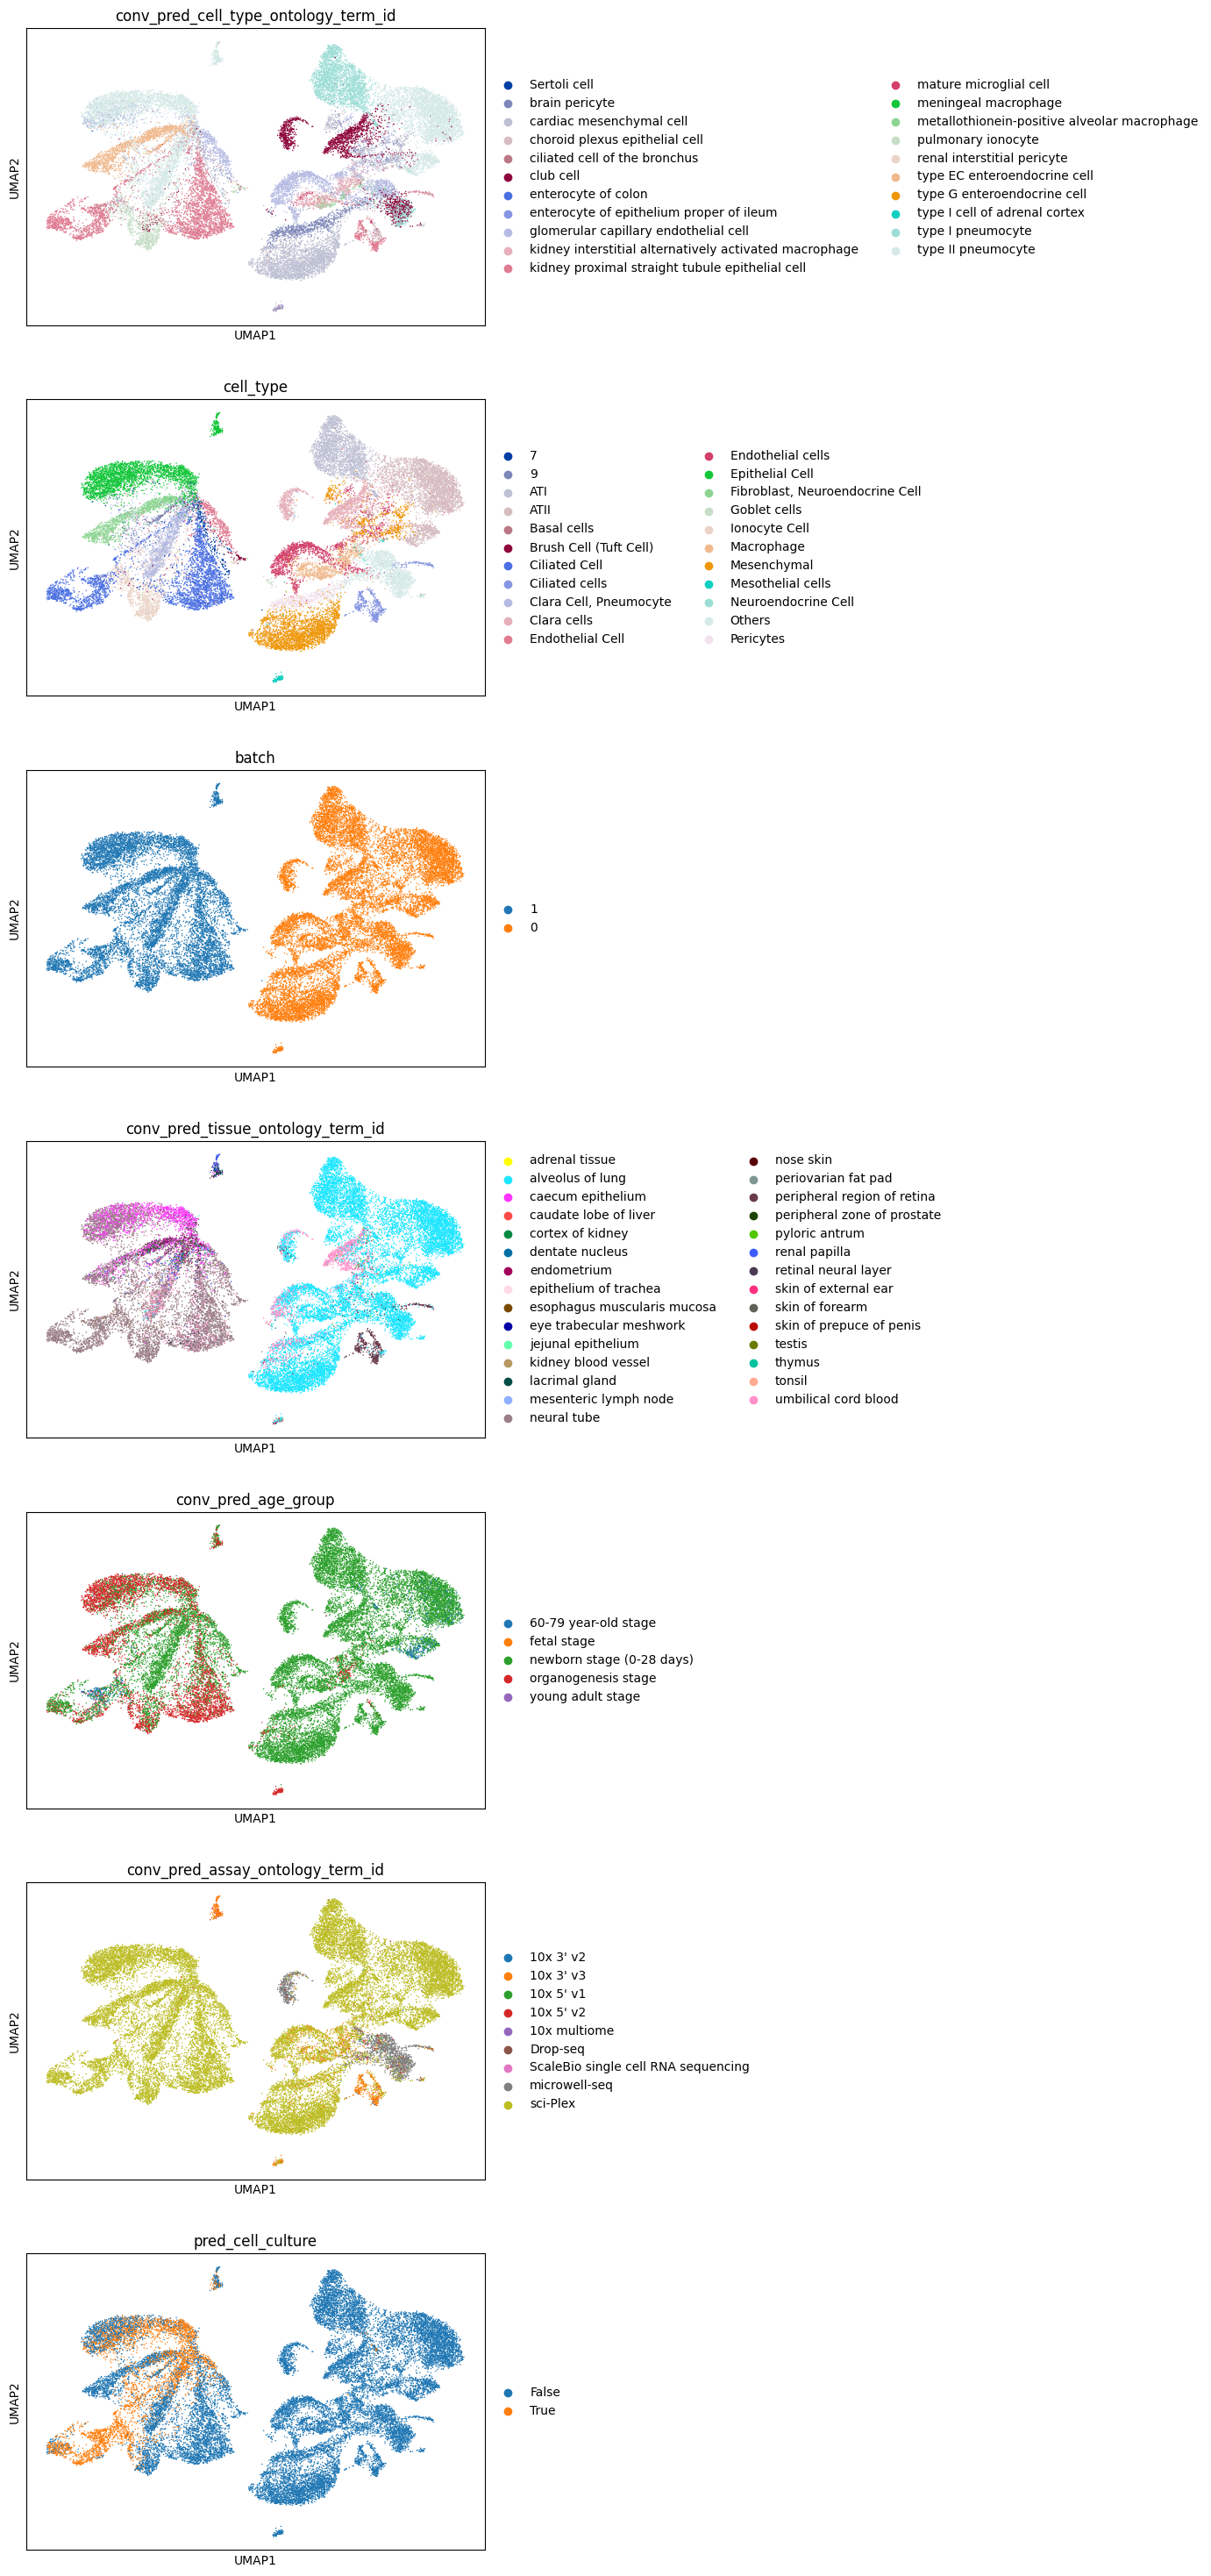

In [15]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch", "conv_pred_tissue_ontology_term_id", "conv_pred_age_group", "conv_pred_assay_ontology_term_id", "pred_cell_culture"],
    ncols=1,
)

In [11]:
bm = Benchmarker(
    n_adata,
    batch_key="batch",  # batch, tech, assay_ontology_term_id, donor_id
    label_key="cell_type_ontology_term_id",  # celltype
    embedding_obsm_keys=["scprint_emb_cell_type_ontology_term_id"],
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    n_jobs=8,
)
bm.benchmark()

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(
Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]Tue Oct 14 15:33:47 2025 INFO isolated labels: no more than 1 batches per label
INFO:2025-10-14 15:33:47,621:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Tue Oct 14 15:33:47 2025 INFO Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Tue Oct 14 15:33:47 2025 WARNING An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not 

INFO     CL:0000064 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000066 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000158 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000165 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000235 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000322 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000669 consists of a single batch or is too small. Skip.                                              
INFO     CL:0002062 consists of a single batch or is too small. Skip.                                              
INFO     CL:0002063 consists of a single batch or is too small. Skip.   

Metrics:  70%|███████   | 7/10 [19:33<03:17, 65.94s/it, Batch correction: kbet_per_label]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 1/1 [19:34<00:00, 1174.23s/it]


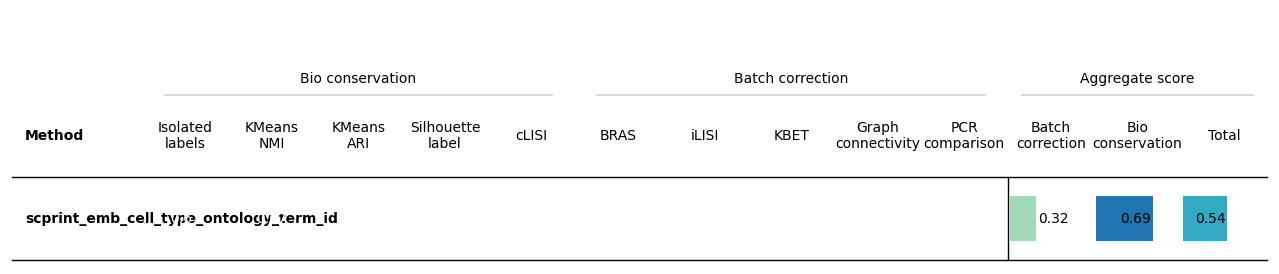

In [12]:
# after fine tuning
bm.plot_results_table(min_max_scale=False)